In [5]:
%matplotlib notebook
import numpy as np
import sigpy as sp
import sigpy.mri as mr
import sigpy.mri.rf as rf
import sigpy.plot as pl
import scipy.signal as signal
import scipy.io as sio
import matplotlib.pyplot as pyplot

<IPython.core.display.Javascript object>


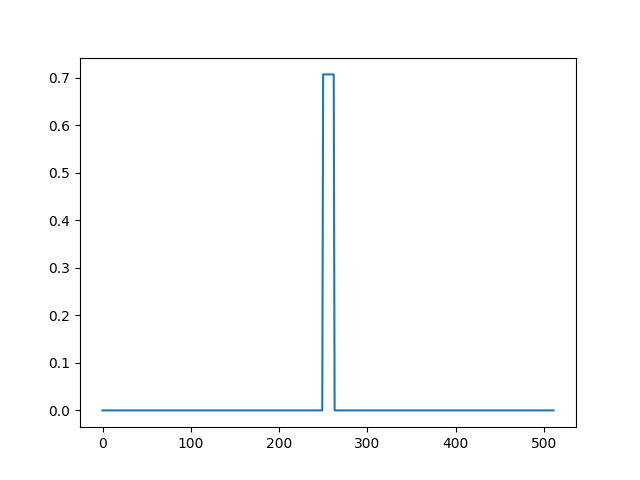

<IPython.core.display.Javascript object>


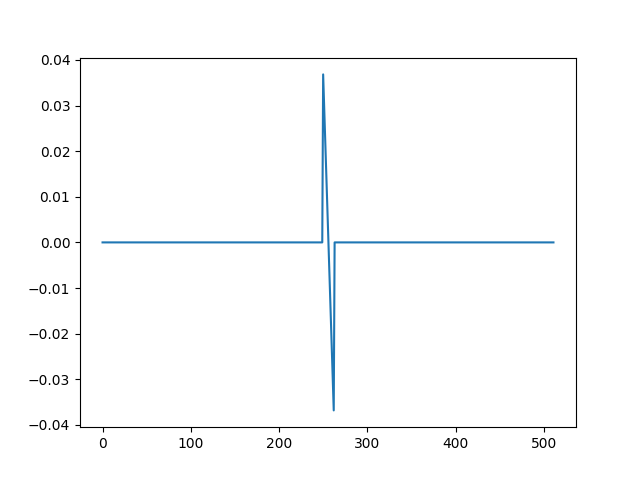

<IPython.core.display.Javascript object>


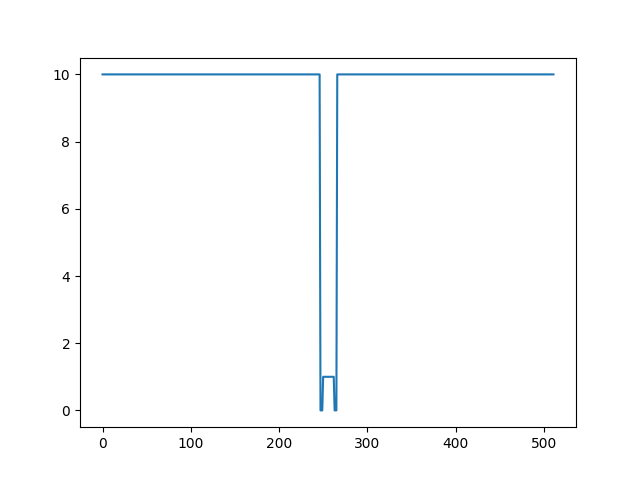

In [6]:
N = 256
tb = 8 # npoints in pulse, tb of pulse
dt = 4e-6 # seconds, sampling rate
os = 2 # spatial oversampling factor
d1 = 0.01
d2 = 0.01 # ripple levels in beta profile

dthick = 4 # slice thickness in cm

# set mag of gamgdt according to tb + dthick
gambar = 4257 # Hz/g
gmag = tb/(N*dt)/dthick/gambar

# get spatial locs + gradient
x = np.arange(0,N*os,1)/N/os-1/2
gamgdt = 2*np.pi*gambar*gmag*dt*np.ones(N)

# set up target beta pattern
d1 = np.sqrt(d1/2) # Mxy -> beta ripple for ex pulse
d2 = d2/np.sqrt(2)
dib = rf.slr.dinf(d1,d2);
ftwb = dib/tb;
fb = np.asarray([0, (1-ftwb)*(tb/2), (1+ftwb)*(tb/2), N/2])/N; # freq edges, normalized to 2*nyquist

dpass = np.abs(x) < fb[1] # passband mask
dstop = np.abs(x) > fb[2] # stopband mask
wb = [1, d1/d2]
w = dpass + wb[1]/wb[0]*dstop # 'points we care about' mask

db = np.sqrt(1/2)*dpass*np.exp(-1j/2*x*2*np.pi) # target beta pattern
pyplot.figure()
pyplot.plot(np.abs(db))
pyplot.figure()
pyplot.plot(np.angle(db))
pyplot.figure()
pyplot.plot(w)


In [8]:
stepsize = 0.001
pulse = np.zeros(N, dtype=complex)

a = np.exp(1j/2*x/(gambar*dt*gmag)*np.sum(gamgdt))
b = np.zeros(a.shape, dtype=complex)

eb = b - db
iters = 1000
cost = np.zeros(iters+1)
cost[0] = np.real(np.sum(w*np.abs(eb)**2))

for ii in range(0, iters, 1):
    
    # calculate search direction
    auxb = w*(b - db)
    drf = rf.optcont.deriv(pulse, x/(gambar*dt*gmag), gamgdt, None, auxb, a, b)
    drf = 1j*np.imag(drf)
    
    # get test point
    pulse -= stepsize*drf
    
    # simulate test point
    [a,b] = rf.optcont.blochsim(pulse, x/(gambar*dt*gmag), gamgdt)
    
    # calculate cost
    eb = b - db
    cost[ii+1] = np.sum(w*np.abs(eb)**2)


<IPython.core.display.Javascript object>


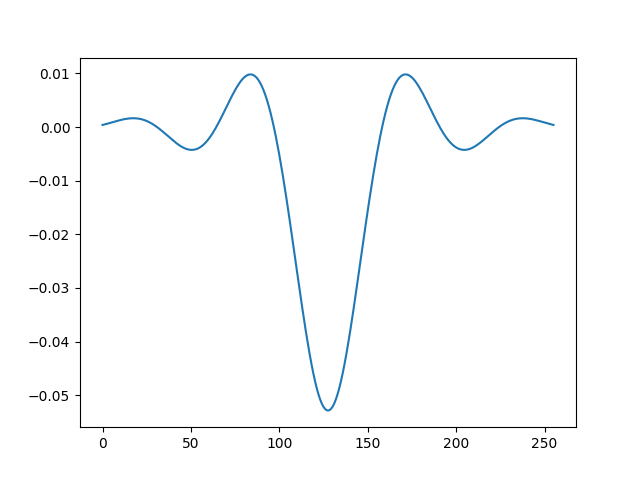

<IPython.core.display.Javascript object>


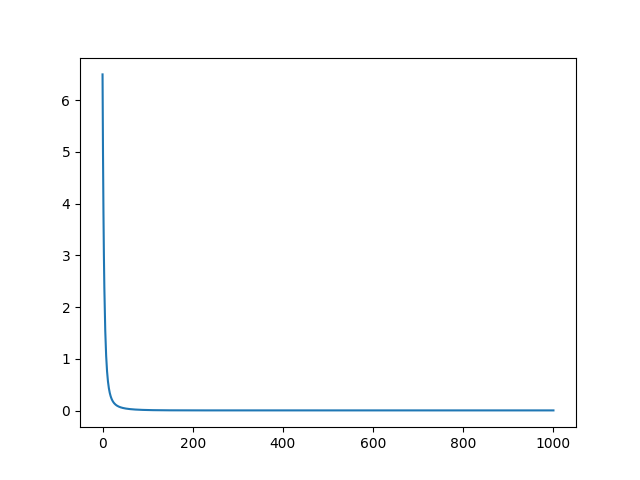

In [10]:
pyplot.figure()
pyplot.plot(np.imag(pulse))
pyplot.figure()
pyplot.plot(cost)

<IPython.core.display.Javascript object>


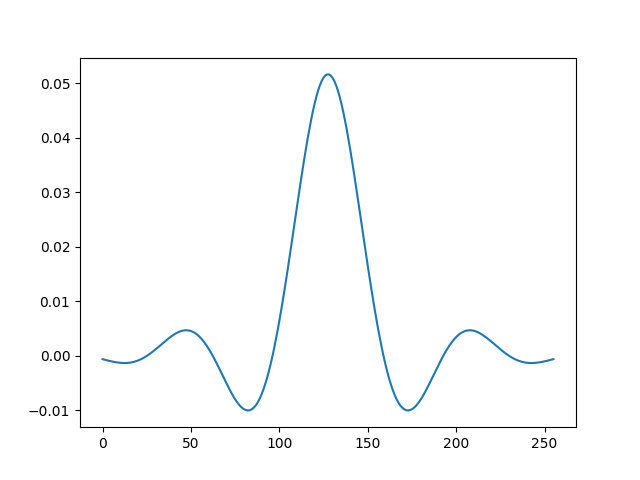

<IPython.core.display.Javascript object>


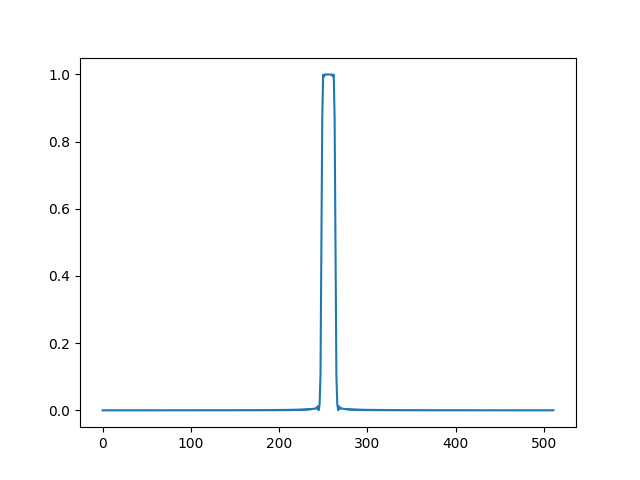

In [12]:
# design an SLR pulse for comparison
rfSLR = rf.slr.dzrf(N, tb, 'ex', 'ls', d1, d2)
# simulate slr pulse using same blochsim 
[a, b] = rf.optcont.blochsim(rfSLR, x/(gambar*dt*gmag), gamgdt)
# plot EX profile
Mxy = 2*np.conj(a)*b
pyplot.figure()
pyplot.plot(np.real(rfSLR))
pyplot.figure()
pyplot.plot(np.abs(Mxy))